# **Non-Linear Spiral Classification**

## **Imports**

In [1]:
# Imports
import torch
from torch import nn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## **Device Agnostic Setting**

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## **Data Creation**

### **Generate Data**

In [3]:
# Number of points per class
N = 5_000

# Number of features
D = 2

# Number of classes
K = 4

# Initialize empty matrix of zeros to store features and labels
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype = 'uint8')

# Traverse for number of features to generate the data
for j in range(K):
    # Track index
    ix = range(N * j, N * (j + 1))

    # Radius
    r = np.linspace(0.0, 1, N) + np.random.randn(N) * 0.1

    # Theta (angle)
    t = np.linspace(j * 2 * np.pi / K, (j + 1) * 2 * np.pi / K, N) + np.random.randn(N) * 0.1

    # Update the value of feature and target
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

### **Visualize Data**

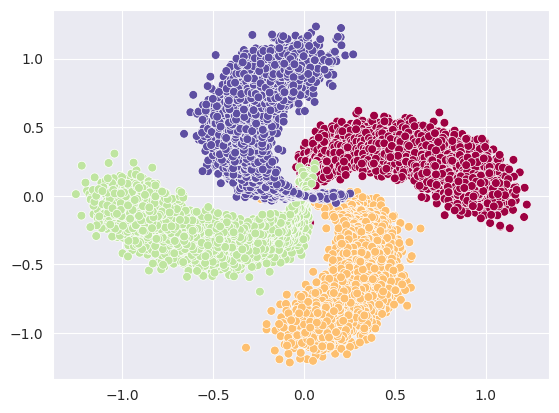

In [4]:
# Visualize the data
sns.scatterplot(x = X[:, 0], y = X[:, 1], c = y, s = 40, cmap = plt.cm.Spectral)
plt.show()

### **Convert Data to Tensors**

In [5]:
# Convert data to tensor
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

In [6]:
# Print the data samples
print(X[:5])
print(y[:5])

tensor([[-0.0041, -0.0727],
        [-0.0133, -0.1144],
        [-0.0004,  0.0633],
        [-0.0050,  0.0487],
        [ 0.0128, -0.1865]])
tensor([0, 0, 0, 0, 0])


## **Train Test Split**

In [7]:
# Split the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# View the shape of train and test set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([16000, 2]),
 torch.Size([4000, 2]),
 torch.Size([16000]),
 torch.Size([4000]))

## **Model Building**

In [8]:
# Create a class for the classification model
class SpiralClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
                (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()

        # Use neural network nn.Sequential() for adding layers to model
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )

    # forward() computation
    def forward(self, x):
        return self.linear_layer_stack(x)

### **Initialize Model**

In [9]:
# Initialize an instance of model
sc_model = SpiralClassificationModel(input_features = D,
                       output_features = K,
                       hidden_units = 8).to(device)
sc_model

SpiralClassificationModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### **Loss, Optimizer and Performance Metrics**

In [10]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(sc_model.parameters(), lr = 1e-1)

In [11]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    # Get the count of correct predictions
    correct_count = torch.eq(y_true, y_pred).sum().item()

    # Calculate the accuracy
    acc = (correct_count / len(y_pred)) * 100

    # Return the accuracy
    return acc

### **Generating Predictions**
`Before Predictions`

In [12]:
# Get logits from the model for training data
y_train_pred_logits = sc_model(X_train.to(device))
y_train_pred_logits[:5]

tensor([[ 0.3803,  0.3056, -0.1670, -0.1486],
        [ 0.4683,  0.2744, -0.2323, -0.1585],
        [ 0.3491,  0.2958, -0.1365, -0.1523],
        [ 0.3728,  0.2863, -0.1537, -0.1553],
        [ 0.3774,  0.3137, -0.1673, -0.1459]], grad_fn=<SliceBackward0>)

In [13]:
# Apply softmax activation to logits to get probability for each class
y_train_pred_probs = torch.softmax(y_train_pred_logits, dim = 1)
y_train_pred_probs[:5]

tensor([[0.3230, 0.2998, 0.1869, 0.1903],
        [0.3503, 0.2886, 0.1739, 0.1872],
        [0.3155, 0.2992, 0.1942, 0.1911],
        [0.3228, 0.2961, 0.1907, 0.1904],
        [0.3214, 0.3016, 0.1865, 0.1905]], grad_fn=<SliceBackward0>)

## **Training and Testing Loop**

### **Move Data to Device**

In [14]:
# Put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### **Training and Evaluation**

In [15]:
# Set pytorch random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 2_000

# Setup empty lists to track model progress
train_loss_values = []
test_loss_values = []
epoch_count = []

# Loop for number of epochs
for epoch in range(epochs):
    # Set the model to training model
    sc_model.train()

    # Get the logits and probabilities
    y_train_pred_logits = sc_model(X_train)
    y_train_pred_probs = torch.softmax(y_train_pred_logits, dim = 1)

    # Get the predicted label from probabilities
    y_train_pred = y_train_pred_probs.argmax(dim = 1)

    # Calculate loss and accuracy
    train_loss = loss_fn(y_train_pred_logits, y_train)
    train_acc = accuracy_fn(y_train, y_train_pred)

    # Oprimizer zero grad
    optimizer.zero_grad()

    # Backpropogate the loss
    train_loss.backward()

    # Optimzer step
    optimizer.step()

    # Set the model to testing mode
    sc_model.eval()

    # Use inference_mode() for faster processing
    with torch.inference_mode():
        # Get the logits and probabilities
        y_test_pred_logits = sc_model(X_test)
        y_test_pred_probs = torch.softmax(y_test_pred_logits, dim = 1)

        # Get the predicted label from probabilities
        y_test_pred = y_test_pred_probs.argmax(dim = 1)

        # Calculate loss and accuracy
        test_loss = loss_fn(y_test_pred_logits, y_test)
        test_acc = accuracy_fn(y_test, y_test_pred)

    # For every epochs track the progress
    if epoch % (epochs // 10) == 0:
        # Update the lists
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.detach().to("cpu").numpy())
        test_loss_values.append(test_loss.detach().to("cpu").numpy())

        # Print the progress
        print(f"Epoch: {epoch}\t| Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Epoch: 0	| Train Loss: 1.4017 | Train Accuracy: 25.0312 | Test Loss: 1.3960 | Test Accuracy: 24.8750
Epoch: 200	| Train Loss: 0.9747 | Train Accuracy: 59.5437 | Test Loss: 0.9680 | Test Accuracy: 59.9750
Epoch: 400	| Train Loss: 0.4464 | Train Accuracy: 90.7875 | Test Loss: 0.4373 | Test Accuracy: 90.8500
Epoch: 600	| Train Loss: 0.2827 | Train Accuracy: 93.0312 | Test Loss: 0.2782 | Test Accuracy: 92.7500
Epoch: 800	| Train Loss: 0.2480 | Train Accuracy: 93.7562 | Test Loss: 0.2444 | Test Accuracy: 93.6250
Epoch: 1000	| Train Loss: 0.2336 | Train Accuracy: 94.2375 | Test Loss: 0.2303 | Test Accuracy: 94.2000
Epoch: 1200	| Train Loss: 0.2257 | Train Accuracy: 94.4875 | Test Loss: 0.2227 | Test Accuracy: 94.4250
Epoch: 1400	| Train Loss: 0.2204 | Train Accuracy: 94.6438 | Test Loss: 0.2177 | Test Accuracy: 94.6000
Epoch: 1600	| Train Loss: 0.2164 | Train Accuracy: 94.7938 | Test Loss: 0.2140 | Test Accuracy: 94.7750
Epoch: 1800	| Train Loss: 0.2129 | Train Accuracy: 94.9750 | Test Loss:

## **Predictions**

### **Get Logits**

In [16]:
# Set model to eval model
sc_model.eval()

# Put model to evaluation model
with torch.inference_mode():
    # Get the logits
    y_test_pred_logits = sc_model(X_test)

# View the logits
y_test_pred_logits[:5]

tensor([[-3.8659,  0.5648,  4.3206, -0.9843],
        [ 8.8423, -0.0759, -8.8331,  1.4707],
        [-2.4197,  5.2396, -0.0110, -5.0626],
        [ 3.5777, -0.1092, -3.3584,  0.8724],
        [-3.4013, -0.6754,  5.1578, -0.3295]])

### **Get Probabilities**

In [17]:
# Get the probabilities
y_test_pred_probs = torch.softmax(y_test_pred_logits, dim = 1)

# Turn probabilities into prediction labels
y_test_pred = y_test_pred_probs.argmax(dim = 1)

### **Classification Report**

In [18]:
# Print classification report
print(classification_report(y_test.to("cpu"), y_test_pred.to("cpu")))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       995
           1       0.96      0.95      0.96      1024
           2       0.93      0.96      0.94      1004
           3       0.97      0.94      0.95       977

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



### **Download File and Import Helper Functions**

In [19]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

### **Decision Boundary**

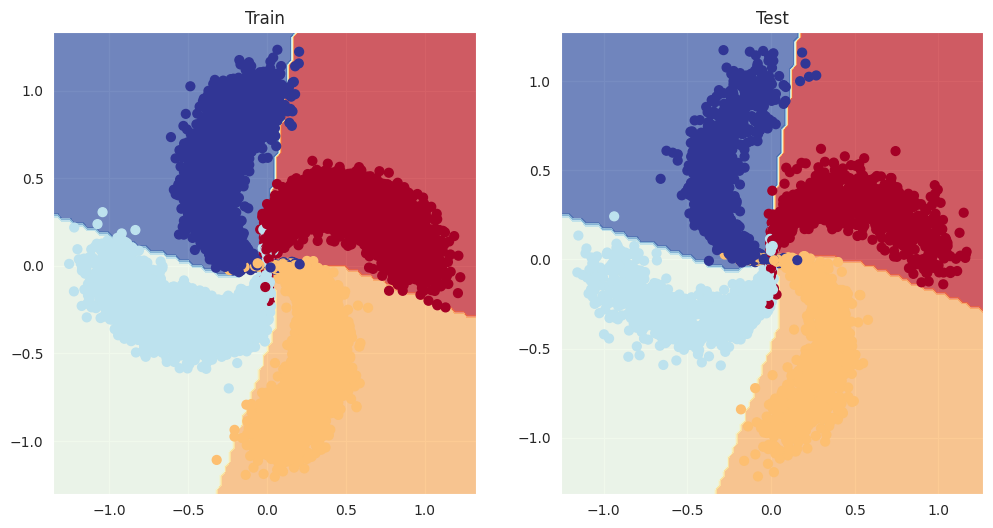

In [20]:
# Chagne figure size
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(sc_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(sc_model, X_test, y_test)

plt.show()

### **PyTorch Metrics**

In [21]:
# Import accuracy from torchmetrics
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics --quiet
    from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.8 MB/s eta 0:00:00


In [22]:
# Setup metric and move to target device
torchmetrics_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device)

In [23]:
# Calculate accuracy
torchmetrics_accuracy(y_test_pred, y_test)

tensor(0.9503)

## **Save Model**

In [24]:
# Mount google drive
from google.colab import drive
drive.mount("./Drive", force_remount = True)

Mounted at ./Drive


In [25]:
# Create models directory
MODEL_PATH = Path("./Drive/MyDrive/PyTorch Course/models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "02_pytorch_non_linear_spiral_classification.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj = sc_model.state_dict(), f = MODEL_SAVE_PATH)

Saving Model to: Drive/MyDrive/PyTorch Course/models/02_pytorch_non_linear_spiral_classification.pth


In [26]:
# Check the saved file path
!ls -l "./Drive/MyDrive/PyTorch Course/models/02_pytorch_non_linear_spiral_classification.pth"

-rw------- 1 root root 3383 Jul 20 15:17 './Drive/MyDrive/PyTorch Course/models/02_pytorch_non_linear_spiral_classification.pth'


## **Load Model**

### **Initialize Model**

In [27]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_sc_model = SpiralClassificationModel(input_features = D,
                              output_features = K,
                              hidden_units = 8).to(device)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_sc_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

### **Generate Outputs**

In [28]:
# Put the loaded model into evaluation mode
loaded_sc_model.eval()

# Put model to evaluation model
with torch.inference_mode():
    # Get the logits
    loaded_y_test_pred_logits = loaded_sc_model(X_test)

# Get the probabilities
loaded_y_test_pred_probs = torch.softmax(loaded_y_test_pred_logits, dim = 1)

# Turn probabilities into prediction labels
loaded_y_test_pred = loaded_y_test_pred_probs.argmax(dim = 1)

In [29]:
# Print the classification report
print(classification_report(y_test.to("cpu"), loaded_y_test_pred.to("cpu")))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       995
           1       0.96      0.95      0.96      1024
           2       0.93      0.96      0.94      1004
           3       0.97      0.94      0.95       977

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000

